In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

from scipy.signal import convolve2d
import numpy as np

In [2]:
class ExponentialSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, a=1.):
        self.a = a
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) # from BaseEstimator
        return self
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) # from BaseEstimator
        return 1 - np.exp(-self.a*X)

class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self
    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

adstock = ColumnTransformer(
                            [
                             ('tv_pipe', Pipeline([
                                                   ('carryover', ExponentialCarryover()),
                                                   ('saturation', ExponentialSaturation())]), ['TV']),
                             ('radio_pipe', Pipeline([
                                                   ('carryover', ExponentialCarryover()),
                                                   ('saturation', ExponentialSaturation())]), ['Radio']),
                             ('banners_pipe', Pipeline([
                                                   ('carryover', ExponentialCarryover()),
                                                   ('saturation', ExponentialSaturation()) ]), ['Banners']),
                            ],
                            remainder='passthrough'
                        )

### Pipeline

In [4]:
model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])

In [5]:
import pandas as pd
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date')
X = data.drop(columns=['Sales'])
y = data['Sales']
model.fit(X, y)
print(cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean())

0.552719007323667


In [13]:
data.head()

,TV,Radio,Banners,Sales
Date,,,,
2018-01-07,13528.1,0.00,0.00,9779.80
2018-01-14,0.0,5349.65,2218.93,13245.19
2018-01-21,0.0,4235.86,2046.96,12022.66
2018-01-28,0.0,3562.21,0.00,8846.95
2018-02-04,0.0,0.00,2187.29,9797.07


### Note: We do not use the standard k-fold cross-validation here because we are dealing with time series data. TimeSeriesSplit is a more reasonable thing to do, and you can read more about it here.

In [6]:
from optuna.integration import OptunaSearchCV
from optuna.distributions import UniformDistribution, IntUniformDistribution

In [7]:
tuned_model = OptunaSearchCV(
    estimator=model,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': UniformDistribution(0, 1),#strength#carryover(check the adstock pipeline)
        'adstock__tv_pipe__carryover__length': IntUniformDistribution(0, 6),#length#carryover
        'adstock__tv_pipe__saturation__a': UniformDistribution(0, 0.01),#saturation#saturartion
        'adstock__radio_pipe__carryover__strength': UniformDistribution(0, 1),
        'adstock__radio_pipe__carryover__length': IntUniformDistribution(0, 6),
        'adstock__radio_pipe__saturation__a': UniformDistribution(0, 0.01),
        'adstock__banners_pipe__carryover__strength': UniformDistribution(0, 1),
        'adstock__banners_pipe__carryover__length': IntUniformDistribution(0, 6),
        'adstock__banners_pipe__saturation__a': UniformDistribution(0, 0.01),
    },
    n_trials=1, #ideally use 1000 here
    cv=TimeSeriesSplit(),
    random_state=0
)


<ipython-input-7-7de1e0fc606f>:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  tuned_model = OptunaSearchCV(


In [14]:
tuned_model

OptunaSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
               estimator=Pipeline(steps=[('adstock',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('tv_pipe',
                                                                           Pipeline(steps=[('carryover',
                                                                                            ExponentialCarryover()),
                                                                                           ('saturation',
                                                                                            ExponentialSaturation())]),
                                                                           ['TV']),
                                                                          ('radio_pipe',
                                                                           Pipeline(ste

In [8]:
print(cross_val_score(tuned_model, X, y, cv=TimeSeriesSplit())) #this gives R square values

C:\Users\Ashwin.Manickam\Anaconda3\lib\site-packages\sklearn\base.py:88: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
[I 2022-06-28 16:59:14,924] A new study created in memory with name: no-name-faa53146-4184-4936-a67f-f6f89fac6277
[I 2022-06-28 16:59:15,014] Trial 0 finished with value: -347726.57392333547 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.009855760506615989, 'adstock__radio_pipe__carryover__strength': 0.1955964101622225, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00980582177099305, 'adstock__banners_pipe__carryover__strength': 0.18048029738995275, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.008463095456331128}. Best is trial 0 with value: -347726.57392333547.
C:\Us

[ 0.21087523  0.20783153 -0.14074812  0.3523962   0.05860336]


In [9]:
tuned_model.fit(X, y)

print(tuned_model.best_params_)
print(tuned_model.best_estimator_.named_steps['regression'].coef_)
print(tuned_model.best_estimator_.named_steps['regression'].intercept_)

[I 2022-06-28 16:59:30,990] A new study created in memory with name: no-name-fa757698-efda-48c0-8753-440abe601bb6
[I 2022-06-28 16:59:31,120] Trial 0 finished with value: 0.1377916398119512 and parameters: {'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.009855760506615989, 'adstock__radio_pipe__carryover__strength': 0.1955964101622225, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00980582177099305, 'adstock__banners_pipe__carryover__strength': 0.18048029738995275, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.008463095456331128}. Best is trial 0 with value: 0.1377916398119512.


{'adstock__tv_pipe__carryover__strength': 0.4860473230215504, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 0.009855760506615989, 'adstock__radio_pipe__carryover__strength': 0.1955964101622225, 'adstock__radio_pipe__carryover__length': 4, 'adstock__radio_pipe__saturation__a': 0.00980582177099305, 'adstock__banners_pipe__carryover__strength': 0.18048029738995275, 'adstock__banners_pipe__carryover__length': 4, 'adstock__banners_pipe__saturation__a': 0.008463095456331128}
[2844.62427429 1677.46582546 2662.89108356]
4468.163983677406


In [12]:
{'adstock__tv_pipe__carryover__strength': 0.5248878517291329, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__saturation__a': 1.4649722346562529e-05, 
 'adstock__radio_pipe__carryover__strength': 0.45523455448406197, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__saturation__a': 0.0001974038926379962,
 'adstock__banners_pipe__carryover__strength': 0.3340342963936898, 'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__saturation__a': 0.007256873558015173}


{'adstock__tv_pipe__carryover__strength': 0.5248878517291329,
 'adstock__tv_pipe__carryover__length': 4,
 'adstock__tv_pipe__saturation__a': 1.4649722346562529e-05,
 'adstock__radio_pipe__carryover__strength': 0.45523455448406197,
 'adstock__radio_pipe__carryover__length': 0,
 'adstock__radio_pipe__saturation__a': 0.0001974038926379962,
 'adstock__banners_pipe__carryover__strength': 0.3340342963936898,
 'adstock__banners_pipe__carryover__length': 0,
 'adstock__banners_pipe__saturation__a': 0.007256873558015173}

In [13]:
X_new = pd.DataFrame({
    'TV': [10000, 0, 0],
    'Radio': [0, 3000, 0],
    'Banners': [1000, 1000, 1000]
})
tuned_model.predict(X_new)

array([ 9975.11715848, 11653.02312007, 11647.7345701 ])

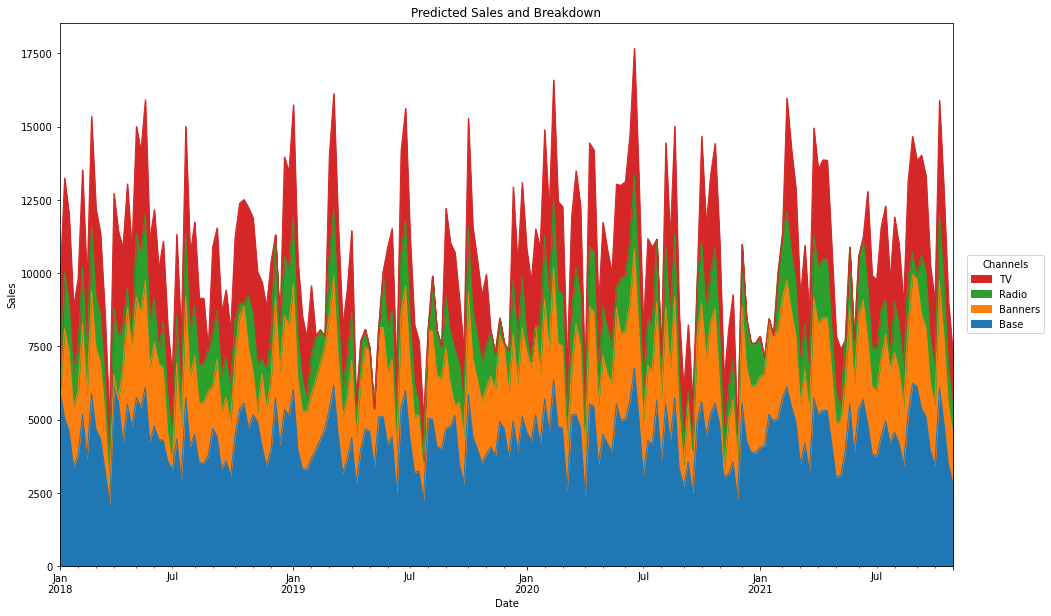

In [14]:
adstock_data = pd.DataFrame(
    tuned_model.best_estimator_.named_steps['adstock'].transform(X),
    columns=X.columns,
    index=X.index
)
weights = pd.Series(
    tuned_model.best_estimator_.named_steps['regression'].coef_,
    index=X.columns
)
base = tuned_model.best_estimator_.named_steps['regression'].intercept_
unadj_contributions = adstock_data.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )
ax = (adj_contributions[['Base', 'Banners', 'Radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

In [23]:
adstock_data

,TV,Radio,Banners
Date,,,
2018-01-07,0.179780,0.000000,0.000000
2018-01-14,0.098796,0.652170,1.000000
2018-01-21,0.053137,0.566635,1.000000
2018-01-28,0.028253,0.504998,0.000000
2018-02-04,0.014930,0.000000,1.000000
...,...,...,...
2021-10-03,0.041749,0.000000,0.999995
2021-10-10,0.169183,0.597914,1.000000
2021-10-17,0.092703,0.593188,0.999999


In [24]:
weights

TV         27926.681000
Radio       4114.461170
Banners     2537.188839
dtype: float64

In [31]:
X

,TV,Radio,Banners
Date,,,
2018-01-07,13528.10,0.00,0.00
2018-01-14,0.00,5349.65,2218.93
2018-01-21,0.00,4235.86,2046.96
2018-01-28,0.00,3562.21,0.00
2018-02-04,0.00,0.00,2187.29
...,...,...,...
2021-10-03,0.00,0.00,1691.68
2021-10-10,11543.58,4615.35,2518.88
2021-10-17,0.00,4556.16,1919.19


In [32]:
tuned_model.best_estimator_.named_steps['adstock'].transform(X)

array([[0.17978019, 0.        , 0.        ],
       [0.09879615, 0.65217011, 0.9999999 ],
       [0.05313697, 0.56663513, 0.99999965],
       [0.02825253, 0.50499832, 0.        ],
       [0.01493035, 0.        , 0.99999987],
       [0.1111826 , 0.57297783, 0.99999948],
       [0.05999031, 0.        , 0.99999992],
       [0.16015241, 0.58692848, 0.99999963],
       [0.08754017, 0.46376902, 0.99999862],
       [0.04694781, 0.59043773, 0.99999981],
       [0.02033415, 0.59030107, 0.        ],
       [0.01072523, 0.        , 0.        ],
       [0.15531819, 0.67531448, 0.        ],
       [0.212318  , 0.        , 0.        ],
       [0.11774149, 0.        , 0.9999984 ],
       [0.19910586, 0.        , 0.99999902],
       [0.11000463, 0.        , 0.99999989],
       [0.17710861, 0.63896764, 0.99999889],
       [0.2227617 , 0.        , 0.99999913],
       [0.22411332, 0.59710308, 0.99999896],
       [0.1192342 , 0.        , 0.99999962],
       [0.20728343, 0.        , 0.99999913],
       [0.

In [40]:
unadj_contributions

,TV,Radio,Banners,Base
Date,,,,
2018-01-07,5020.663906,0.000000,0.000000,5348.966159
2018-01-14,2759.048639,2683.328585,2537.188582,5348.966159
2018-01-21,1483.939148,2331.398245,2537.187942,5348.966159
2018-01-28,788.999375,2077.795974,0.000000,5348.966159
2018-02-04,416.954988,0.000000,2537.188515,5348.966159
...,...,...,...,...
2021-10-03,1165.913078,0.000000,2537.177014,5348.966159
2021-10-10,4724.727019,2460.091906,2537.188810,5348.966159
2021-10-17,2588.898671,2440.648328,2537.186570,5348.966159


In [41]:
unadj_contributions.sum(axis=1)

Date
2018-01-07    10369.630065
2018-01-14    13328.531965
2018-01-21    11701.491494
2018-01-28     8215.761508
2018-02-04     8303.109662
                  ...     
2021-10-03     9052.056250
2021-10-10    15070.973895
2021-10-17    12915.699728
2021-10-24     9157.433876
2021-10-31     8560.818277
Length: 200, dtype: float64

In [44]:
y

Date
2018-01-07     9779.80
2018-01-14    13245.19
2018-01-21    12022.66
2018-01-28     8846.95
2018-02-04     9797.07
                ...   
2021-10-03     9030.17
2021-10-10    15904.11
2021-10-17    12839.29
2021-10-24     9063.45
2021-10-31     7250.21
Name: Sales, Length: 200, dtype: float64

In [45]:
unadj_contributions.div(unadj_contributions.sum(axis=1), axis=0).mul(y, axis=0)

,TV,Radio,Banners,Base
Date,,,,
2018-01-07,4735.085877,0.000000,0.000000,5044.714123
2018-01-14,2741.796586,2666.550002,2521.323798,5315.519614
2018-01-21,1524.668530,2395.387668,2606.825634,5495.778168
2018-01-28,849.615463,2237.425840,0.000000,5759.908696
2018-02-04,491.976786,0.000000,2993.699288,6311.393926
...,...,...,...,...
2021-10-03,1163.094109,0.000000,2531.042574,5336.033317
2021-10-10,4985.913900,2596.087855,2677.446740,5644.661505
2021-10-17,2573.582656,2426.209368,2522.176487,5317.321489


In [ ]:
base = tuned_model.best_estimator_.named_steps['regression'].intercept_
unadj_contributions = adstock_data.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

In [15]:
tuned_model.best_estimator_.named_steps['regression'].intercept_

4468.163983677406

In [16]:
unadj_contributions

,TV,Radio,Banners,Base
Date,,,,
2018-01-07,2844.624274,0.000000,0.000000,4468.163984
2018-01-14,2844.624274,1677.465825,2662.891065,4468.163984
2018-01-21,2844.624274,1677.465825,2662.891081,4468.163984
2018-01-28,2844.623636,1677.465825,2599.526538,4468.163984
2018-02-04,2842.955620,1677.216464,2662.891071,4468.163984
...,...,...,...,...
2021-10-03,2844.624274,1677.341300,2662.890333,4468.163984
2021-10-10,2844.624274,1677.465825,2662.891083,4468.163984
2021-10-17,2844.624274,1677.465825,2662.891080,4468.163984


In [17]:
adj_contributions

,TV,Radio,Banners,Base
Date,,,,
2018-01-07,3804.274853,0.000000,0.000000,5975.525147
2018-01-14,3233.254929,1906.640078,3026.693451,5078.601542
2018-01-21,2934.825748,1730.657346,2747.329895,4609.847011
2018-01-28,2171.416810,1280.477827,1984.324235,3410.731128
2018-02-04,2390.532335,1410.306993,2239.122962,3757.107710
...,...,...,...,...
2021-10-03,2204.359130,1299.807022,2063.529679,3462.474169
2021-10-10,3882.318183,2289.390600,3634.290323,6098.110894
2021-10-17,3134.171546,1848.210925,2933.940180,4922.967349


In [18]:
y

Date
2018-01-07     9779.80
2018-01-14    13245.19
2018-01-21    12022.66
2018-01-28     8846.95
2018-02-04     9797.07
                ...   
2021-10-03     9030.17
2021-10-10    15904.11
2021-10-17    12839.29
2021-10-24     9063.45
2021-10-31     7250.21
Name: Sales, Length: 200, dtype: float64